In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import glob
import matplotlib.pyplot as plt
import seaborn as sb    


##  All training data sets evaluation 

In [2]:
dfall=rm.comb_eval(models=['Md','Ni','Ib','Wm','De','So','Hc','Md-loo','Ni-loo','Ib-loo','Wm-loo','De-loo','So-loo'])

In [4]:
dfall['model'].fillna('avg',inplace=True)

In [5]:
dfall['nanY']=np.isnan(dfall.noiseceiling_Y)
dfall['nanXY']=np.isnan(dfall.noiseceiling_XY)
dfall['nanXR']=np.isnan(dfall.noise_X_R)

In [8]:
pd.pivot_table(data=dfall[dfall.model=='loo'],index='train_dataset',columns='eval_dataset',values='R_eval',aggfunc='count')

eval_dataset,Demand,IBC,MDTB,Nishimoto,Somatotopic,WMFS
train_dataset,,,,,,
Demand,259.0,NaN,NaN,NaN,NaN,NaN
IBC,NaN,84.0,NaN,NaN,NaN,NaN
MDTB,NaN,NaN,216.0,NaN,NaN,NaN
Nishimoto,NaN,NaN,NaN,42.0,NaN,NaN
Somatotopic,NaN,NaN,NaN,NaN,56.0,NaN
WMFS,NaN,NaN,NaN,NaN,NaN,144.0


## Overfitting to subjects 
To study overfitting of the group model to the subjects/data contained in training and test set
We compare the full group model with the leave-one-subject out...
Results indicate very strong overfitting

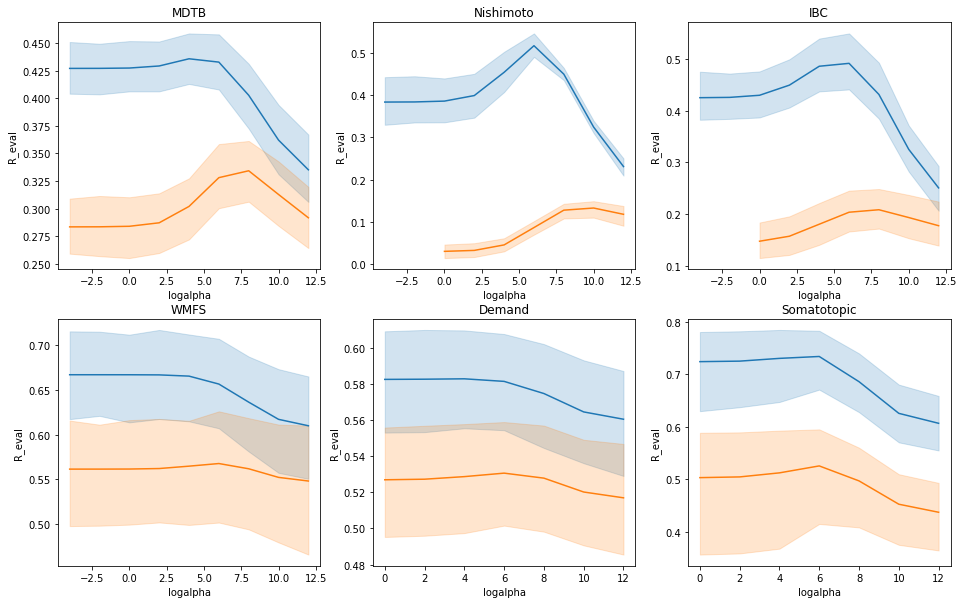

In [9]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=dfall[(dfall.eval_dataset==ed) & (dfall.train_dataset==ed)]
    plt.title(ed)
    sns.lineplot(data=d,y='R_eval',x='logalpha',hue='model',legend=None)

In [10]:
df=dfall[(dfall.eval_dataset=='MDTB') & (dfall.train_dataset=='MDTB') & (dfall.logalpha==8)] 
df.pivot_table(index=None,columns='model',values='R_eval',aggfunc='mean')

model,avg,loo
R_eval,0.40261,0.334225


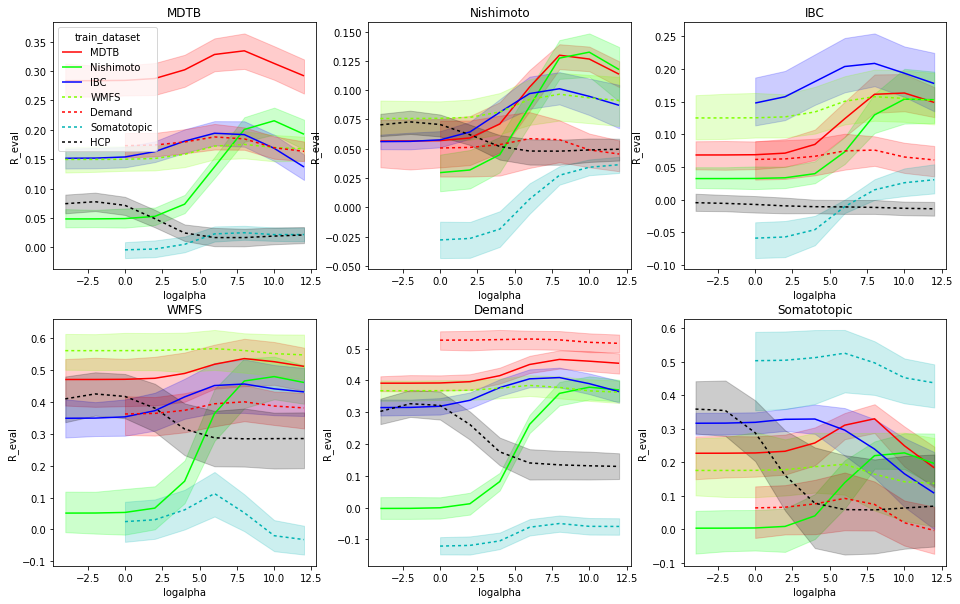

In [11]:
plt.figure(figsize=(16,10))
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']
ho = ['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic','HCP']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7],[0,0,0]]
dashes = [[1,0],[1,0],[1,0],[2,2],[2,2],[2,2],[2,2]]

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=dfall[(dfall.eval_dataset==ed) 
            & ((dfall.train_dataset!=ed) 
            | (dfall.model=='loo'))]
    plt.title(ed)
    if i==0:
        sns.lineplot(data=d,y='R_eval',x='logalpha',hue='train_dataset',        palette=palette,style='train_dataset',
        hue_order=ho,style_order=ho,
        dashes=dashes)
    else: 
        sns.lineplot(data=d,y='R_eval',x='logalpha',hue='train_dataset',palette=palette,style='train_dataset',
        hue_order=ho,style_order=ho,dashes=dashes,legend=None)


<AxesSubplot:xlabel='logalpha', ylabel='R_eval'>

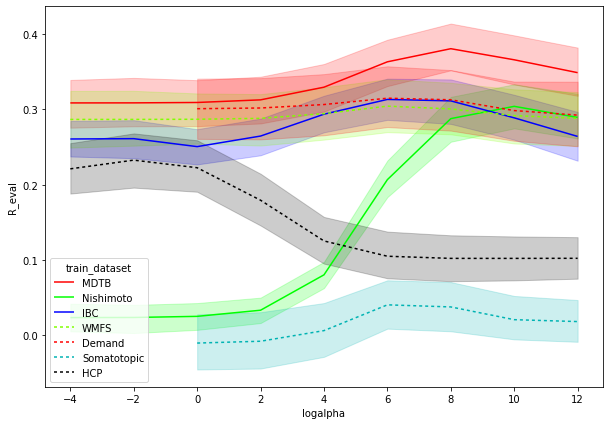

In [12]:
# Plot all evaluations on different datasets 
plt.figure(figsize=(10,7))
d=dfall[(dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo')]
sns.lineplot(data=d,y='R_eval',x='logalpha',
             hue='train_dataset',style='train_dataset',
             hue_order=ho,style_order=ho,
             palette=palette,dashes=dashes)


In [13]:
# determine best logalpha for each model 
pd.pivot_table(d,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean')

R_eval                                                    \
logalpha          -4.0      -2.0       0.0       2.0       4.0       6.0    
train_dataset                                                               
Demand              NaN       NaN  0.301033  0.301976  0.306572  0.314979   
HCP            0.221187  0.232746  0.222668  0.179499  0.125431  0.105120   
IBC            0.260821  0.261256  0.250690  0.264725  0.293734  0.313371   
MDTB           0.308721  0.308791  0.309302  0.312792  0.329620  0.363307   
Nishimoto      0.023652  0.023816  0.025287  0.033429  0.080428  0.206840   
Somatotopic         NaN       NaN -0.010177 -0.007756  0.006354  0.040580   
WMFS           0.286810  0.286834  0.287011  0.288242  0.294464  0.304461   

                                             
logalpha           8.0       10.0      12.0  
train_dataset                                
Demand         0.312883  0.298562  0.292521  
HCP            0.102282  0.102265  0.102380  
IBC            0.311426  0.288904  0.264223  
MDTB           0.380717  0.365992  0.348898  
Nishimoto      0.287860  0.304179  0.289467  
Somatotopic    0.037803  0.020891  0.018360  
WMFS           0.300744  0.291866  0.288250

In [50]:
A = pd.pivot_table(d,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a=np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
bestla

,best_logalpha
train_dataset,
Demand,6.0
HCP,-2.0
IBC,6.0
MDTB,8.0
Nishimoto,10.0
Somatotopic,6.0
WMFS,6.0


## Summary Graph of all evaluated at their best hyperparameters


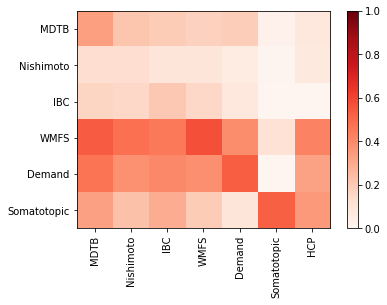

In [146]:

dfall['isbest'] = dfall.logalpha.values  == bestla.loc[dfall.train_dataset].values.flatten()
d=dfall[((dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo'))& dfall.isbest]


V=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['R_eval'])
A=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['noiseceiling_XY'])

V=V.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]
A=A.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]

plt.imshow(V.values,cmap='Reds',vmin=0,vmax=1)
ax=plt.gca()
ev_labels = V.index.values
tr_labels = A.columns.get_level_values(1).values
plt.xticks(np.arange(7),tr_labels)
ax.set_xticklabels(tr_labels, rotation = 90)
plt.yticks(np.arange(6),ev_labels)
plt.colorbar()

<AxesSubplot:xlabel='train_dataset', ylabel='R_eval'>

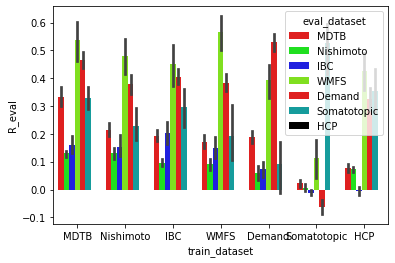

In [147]:
ho = ['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic','HCP']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7],[0,0,0]]
sb.barplot(data=d,x='train_dataset',y='R_eval',order=tr_labels,palette=palette,hue='train_dataset',hue_order=tr_labels)
